# 我想到的一个是找最低点。
这样的话，问题就由一个回归问题变为一个分类问题。  
如以过去N天的(股价，成交量，时间（季度、月份），其它股票、指数、汇率、油价，等等)组成一个特征序列，来预测次日的股价是否是最低点。
最低点的判断依据：未来T天的股价收盘价均不小于预测序列最后一日的收盘价，且未来T天的收盘价最高点大于预测序列最后一日的收盘价的Z%

In [39]:
import pandas as pd
import numpy as np
import tushare as ts
from datetime import datetime, timedelta
from collections import Counter
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.recurrent import GRU, LSTM
from keras.optimizers import Adam
import time
from sklearn.metrics import accuracy_score, classification_report
from keras.models import load_model
import os
import sys
sys.path.append('/Users/luoyonggui/PycharmProjects/mayiutils_n1/mayiutils/config')
from logging_utils import get_logger
LOG_PATH = '/Users/luoyonggui/Documents/logs'
log_path = os.path.join(LOG_PATH, 'output.log')
MODULE_NAME = 'stock_predict'
logger = get_logger(MODULE_NAME, file_handler=True, log_path=log_path)
sys.path.append('/Users/luoyonggui/PycharmProjects/mayiutils_n1/mayiutils/db')
from pymongo_wrapper import PyMongoWrapper
sys.path.append('/Users/luoyonggui/PycharmProjects/mayiutils_n1/mayiutils/finance')
from stock_wrapper import get_tushare_pro

In [3]:
stock_dict = pd.read_pickle('/Users/luoyonggui/PycharmProjects/mayiutils_n1/mayiutils/finance/data/stock_dict.pkl')

# 数据准备

In [5]:
mongo = PyMongoWrapper()

In [6]:
table = mongo.getCollection('finance', stock_dict.loc['东方航空'])

In [10]:
df = pd.DataFrame(list(mongo.findAll(table, fieldlist=['trade_date','close','pct_chg', 'vol', 'amount'])))
df.set_index('trade_date', inplace=True)
df.head()

,amount,close,pct_chg,vol
trade_date,,,,
2001-01-02,8368.321,5.69,1.61,14808.76
2001-01-03,8896.981,5.69,0.00,15642.39
2001-01-04,9738.521,5.69,0.00,17148.66
2001-01-05,14105.074,5.74,0.88,24655.30
2001-01-08,10843.115,5.69,-0.87,19110.72


In [11]:
import ffn

## 以起始第一天的开盘价为净值1，计算每日净值

In [12]:
df['net_worth'] = (1+df['pct_chg']/100).cumprod()

## 以起始第一天的成交额为净值1，计算每日成交额净值

In [13]:
st = (1+ffn.to_returns(df['amount'])).cumprod()
st.loc['2001-01-02'] = 1
df['net_amount'] = st

In [14]:
st = (1+ffn.to_returns(df['vol'])).cumprod()
st.loc['2001-01-02'] = 1
df['net_vol'] = st

In [15]:
df.head()

,amount,close,pct_chg,vol,net_worth,net_amount,net_vol
trade_date,,,,,,,
2001-01-02,8368.321,5.69,1.61,14808.76,1.016100,1.000000,1.000000
2001-01-03,8896.981,5.69,0.00,15642.39,1.016100,1.063174,1.056293
2001-01-04,9738.521,5.69,0.00,17148.66,1.016100,1.163737,1.158008
2001-01-05,14105.074,5.74,0.88,24655.30,1.025042,1.685532,1.664913
2001-01-08,10843.115,5.69,-0.87,19110.72,1.016124,1.295734,1.290501


In [16]:
df['net_worth'].max()

4.138333880666785

## 绘制时间序列图

In [17]:
import matplotlib.pyplot as plt
# 支持中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


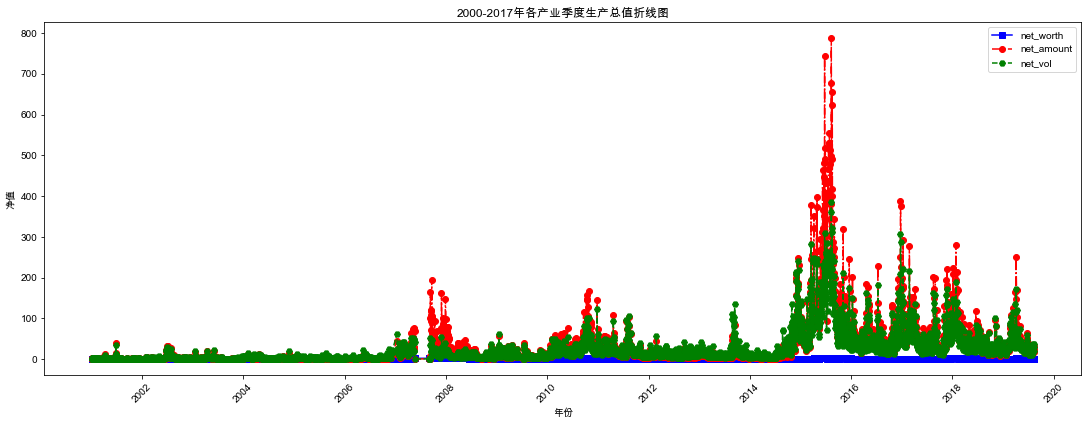

In [18]:
fig =plt.figure(figsize=(18,7)) # 创建画布
ax = fig.add_axes([0.15,0.2,0.8,0.7]) # Axes是画布上的绘图区域
plt.plot(df.index, df['net_worth'],'bs-',
       df.index, df['net_amount'],'ro-.',
       df.index, df['net_vol'],'gH--')## 绘制折线图
plt.xlabel('年份')## 添加横轴标签
plt.ylabel('净值')## 添加y轴名称
plt.xticks(rotation=45)
plt.title('2000-2017年各产业季度生产总值折线图')## 添加图表标题
plt.legend(['net_worth','net_amount','net_vol'])
# plt.savefig('2000-2017年季度各产业生产总值折线图.pdf')
plt.show()

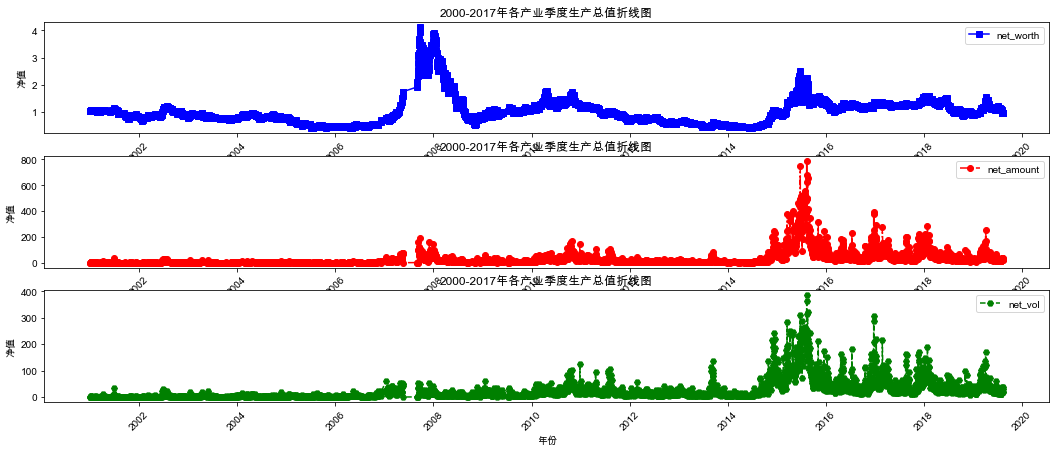

In [19]:
fig =plt.figure(figsize=(18,7)) # 创建画布
## 子图
ax3 = fig.add_subplot(3,1,1)
plt.plot(df.index, df['net_worth'],'bs-')
plt.xlabel('年份')## 添加横轴标签
plt.ylabel('净值')## 添加y轴名称
plt.xticks(rotation=45)
plt.title('2000-2017年各产业季度生产总值折线图')## 添加图表标题
plt.legend(['net_worth'])
## 子图
ax3 = fig.add_subplot(3,1,2)
plt.plot(df.index, df['net_amount'],'ro-.')
plt.xlabel('年份')## 添加横轴标签
plt.ylabel('净值')## 添加y轴名称
plt.xticks(rotation=45)
plt.title('2000-2017年各产业季度生产总值折线图')## 添加图表标题
plt.legend(['net_amount'])
## 子图
ax3 = fig.add_subplot(3,1,3)
plt.plot(df.index, df['net_vol'],'gH--')## 绘制折线图
plt.xlabel('年份')## 添加横轴标签
plt.ylabel('净值')## 添加y轴名称
plt.xticks(rotation=45)
plt.title('2000-2017年各产业季度生产总值折线图')## 添加图表标题
plt.legend(['net_vol'])
# plt.savefig('2000-2017年季度各产业生产总值折线图.pdf')
plt.show()

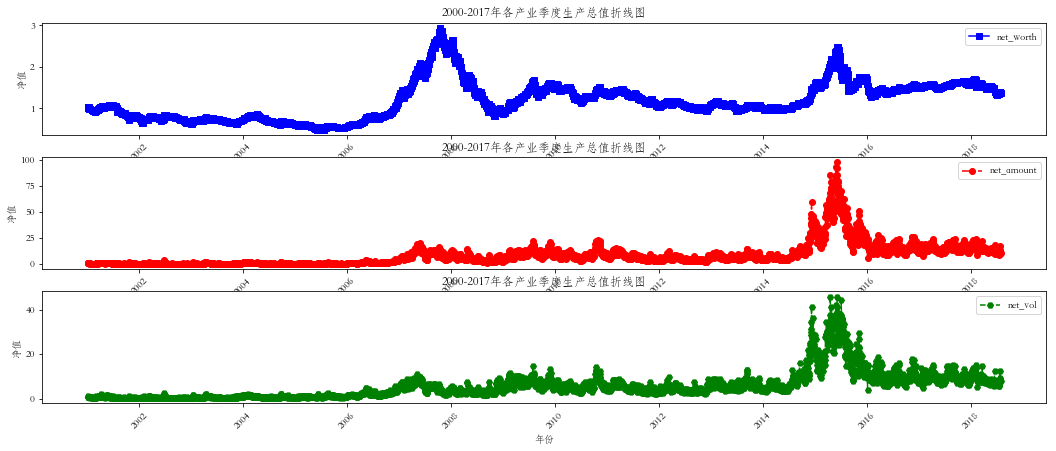

In [69]:
fig =plt.figure(figsize=(18,7)) # 创建画布
## 子图
ax3 = fig.add_subplot(3,1,1)
plt.plot(df.index, df['net_worth'],'bs-')
plt.xlabel('年份')## 添加横轴标签
plt.ylabel('净值')## 添加y轴名称
plt.xticks(rotation=45)
plt.title('2000-2017年各产业季度生产总值折线图')## 添加图表标题
plt.legend(['net_worth'])
## 子图
ax3 = fig.add_subplot(3,1,2)
plt.plot(df.index, df['net_amount'],'ro-.')
plt.xlabel('年份')## 添加横轴标签
plt.ylabel('净值')## 添加y轴名称
plt.xticks(rotation=45)
plt.title('2000-2017年各产业季度生产总值折线图')## 添加图表标题
plt.legend(['net_amount'])
## 子图
ax3 = fig.add_subplot(3,1,3)
plt.plot(df.index, df['net_vol'],'gH--')## 绘制折线图
plt.xlabel('年份')## 添加横轴标签
plt.ylabel('净值')## 添加y轴名称
plt.xticks(rotation=45)
plt.title('2000-2017年各产业季度生产总值折线图')## 添加图表标题
plt.legend(['net_vol'])
# plt.savefig('2000-2017年季度各产业生产总值折线图.pdf')
plt.show()

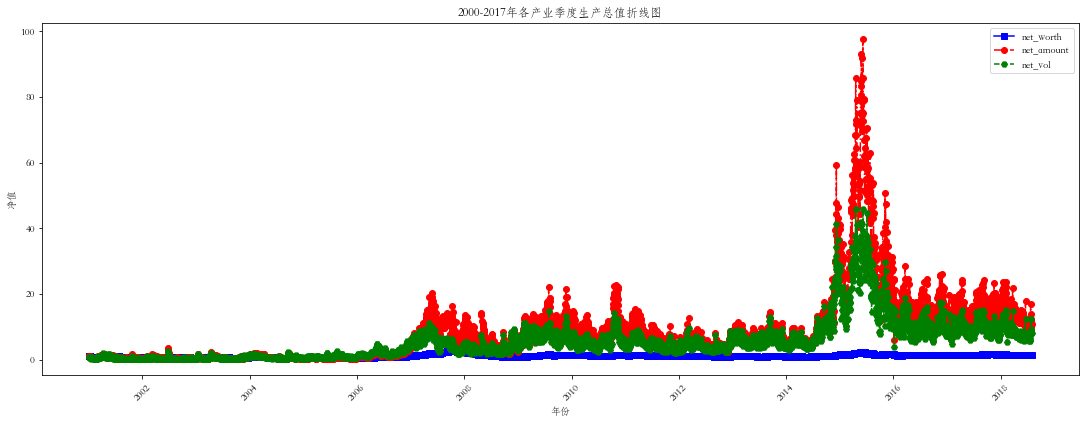

In [68]:
fig =plt.figure(figsize=(18,7)) # 创建画布
ax = fig.add_axes([0.15,0.2,0.8,0.7]) # Axes是画布上的绘图区域
plt.plot(df.index, df['net_worth'],'bs-',
       df.index, df['net_amount'],'ro-.',
       df.index, df['net_vol'],'gH--')## 绘制折线图
plt.xlabel('年份')## 添加横轴标签
plt.ylabel('净值')## 添加y轴名称
plt.xticks(rotation=45)
plt.title('2000-2017年各产业季度生产总值折线图')## 添加图表标题
plt.legend(['net_worth','net_amount','net_vol'])
# plt.savefig('2000-2017年季度各产业生产总值折线图.pdf')
plt.show()

# 构建训练集

In [30]:
def build_flag(df,series_len,pro_len, fieldnamelist):
    '''
    构建训练集

    series_len: 参考的之前的序列范围。如以之前的series_len个序列预测下一个序列，则series_len=series_len
    pro_len: 预测日以后的天数（含预测日）
    '''
    r = list()
    l1 = df['net_worth'].to_list()
    dfr = df.iloc[series_len:(df.shape[0]-pro_len)].copy()  # 有标签的df
    for i in range(series_len,(df.shape[0]-pro_len)):
        final_list = list()
        laa = l1[i:i+pro_len]
        #最低点和买点的关系：最低点一定是买点，买点不一定是最低点
        #买点特征
        #买点日之后14日最高收盘价涨幅超过0.05，最低价不得低于买点日收盘价
        #最低点的特征：在买点特征的基础上
        #最低日收盘价低于前一日收盘价

        f1 = 0 # 买点标志 1表示买点
        f2 = 0 # 最低点标志 1表示最低点
        if (max(laa) - l1[i])/l1[i] > 0.05 and min(laa[1:]) > l1[i]:#未来pro_len日最高收盘价涨幅超过0.05
            f1 = 1
            if l1[i] < l1[i-1]:
                f2 = 1
        final_list.append(df[fieldnamelist].values[(i-series_len) : i])
        final_list.append(f1)
        final_list.append(f2)
        r.append(final_list) 
    dfr['buy'] = [(i[1]) for i in r]
    dfr['min'] = [(i[2]) for i in r]
    return r, dfr

In [31]:
fieldlist = ['net_worth','net_vol', 'net_amount']
# 参考之前180天的序列来做下一个交易日的预测。 打标签时考虑 之后15-1个交易日的价格
ll, dfr = build_flag(df,180,15,fieldlist)

In [32]:
dfr.head()

,amount,close,pct_chg,vol,net_worth,net_amount,net_vol,buy,min
trade_date,,,,,,,,,
2001-10-10,2917.326,4.40,-3.51,6533.00,0.787866,0.348615,0.441158,0,0
2001-10-11,3514.590,4.18,-5.00,8330.52,0.748473,0.419987,0.562540,1,1
2001-10-12,4253.589,4.30,2.87,10052.02,0.769954,0.508297,0.678789,0,0
2001-10-15,2164.526,4.32,0.47,5023.78,0.773573,0.258657,0.339244,0,0
2001-10-16,1397.840,4.25,-1.62,3265.54,0.761041,0.167039,0.220514,0,0


### 问题：数据不均衡

In [23]:
yy = [(i[-2],i[-1]) for i in ll]
Counter(yy)

Counter({(0, 0): 3558, (1, 1): 248, (1, 0): 315})

In [47]:
# 买点
y = [(i[1]) for i in ll]
Counter(y)

Counter({0: 3558, 1: 563})

In [46]:
# 买点
y111 = [(i[1]) for i in ll[:-250]]
Counter(y)

Counter({0: 3339, 1: 532})

In [34]:
# 最低点
y1 = [(i[2]) for i in ll]
Counter(y)

Counter({0: 3558, 1: 563})

In [48]:
y = np_utils.to_categorical(y,num_classes=2)

In [49]:
y[:5]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [50]:
x = np.array([i[0] for i in ll])

In [52]:
x_train, x_val, y_train, y_val = train_test_split(x[:-250], y[:-250], test_size=0.25, random_state=14, stratify=y[:-250])

In [53]:
x_test, y_test = x[-250:], y[-250:]

In [54]:
x_train.shape

(2903, 180, 3)

In [ ]:
# def preprocess(self,ll,balance=True):
#     '''
#     数据预处理，获得可用于训练的set
#     '''
#     ll1 = [i for i in ll if i[1]==1]#买点数据
#     #均衡数据
#     ll2 = ll
#     if balance:
#         ll2 += ll1* (round(len(ll)/len(ll1))-1)
#     ll3 = [(i[1],i[2]) for i in ll2]
#     x = np.array([i[0] for i in ll2])
#     y1 = np.array([[i[1]] for i in ll2])#买点
#     y2 = np.array([[i[2]] for i in ll2])#最低点
#     print(Counter(ll3))
#     return x,np_utils.to_categorical(y1,num_classes=2),np_utils.to_categorical(y2,num_classes=2)

# 建模

## lstm_model

### 问题：训练参数远大于训练集量
* dropout
* 数据增强

In [55]:
model = Sequential()

# 循环神经网络
model.add(LSTM(
    units = 256, # 输出
    input_shape = (180,3), #输入
))
model.add(Dropout(0.5))
model.add(Dense(200,activation='relu'))
# 输出层
model.add(Dense(2,activation='softmax'))

# 定义优化器
adam = Adam(lr=1e-4)

# 定义优化器，loss function，训练过程中计算准确率
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               266240    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               51400     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 402       
Total params: 318,042
Trainable params: 318,042
Non-trainable params: 0
_________________________________________________________________
None


In [89]:
print('start')

start


In [ ]:
start = time.time()
batch_size=128
epochs=50
history = model.fit(x_train,y_train,batch_size,epochs, validation_data=(x_val, y_val))
print(f'@ Total Time Spent: {(time.time() - start)//60} minites')

Train on 2903 samples, validate on 968 samples
Epoch 1/50
2903/2903 [==============================] - 14s 5ms/step - loss: 0.2331 - acc: 0.9022 - val_loss: 0.3478 - val_acc: 0.8791
Epoch 2/50
2903/2903 [==============================] - 17s 6ms/step - loss: 0.2379 - acc: 0.8967 - val_loss: 0.3636 - val_acc: 0.8678
Epoch 3/50
2903/2903 [==============================] - 16s 6ms/step - loss: 0.2406 - acc: 0.9015 - val_loss: 0.3667 - val_acc: 0.8688
Epoch 4/50
2903/2903 [==============================] - 15s 5ms/step - loss: 0.2430 - acc: 0.9001 - val_loss: 0.3516 - val_acc: 0.8719
Epoch 5/50
2903/2903 [==============================] - 16s 5ms/step - loss: 0.2356 - acc: 0.8984 - val_loss: 0.3496 - val_acc: 0.8750
Epoch 6/50
 768/2903 [======>.......................] - ETA: 10s - loss: 0.2092 - acc: 0.9115

In [121]:
history

In [106]:
#     def evaluate(self,x_test,y_test):
#         # 评估模型
#         loss,accuracy = t._model.evaluate(x_test,y_test)
#         print('test loss',loss)
#         print('test accuracy',accuracy)
#         return loss,accuracy
#     def build_x(self, df,series_len, start):
#         '''
#         构建预测序列

#         series_len: 参考的之前的序列范围。如以之前的series_len个序列预测下一个序列，则series_len=series_len
#         '''
#         ll = list()
#         l1 = list(df['close_1'])
#         l4 = list(df['vol_1'])
#         l5 = list(df['amount_1'])
#         for i in range(df.shape[0]-start,df.shape[0]):
#             final_list = list()
#             l2 = l1[i-series_len : i]
#             ll.append(list(zip(l1[i-series_len : i],l4[i-series_len : i],l5[i-series_len : i])))    
#         return ll
#     def predict(self, x_list):
#         '''
#         x_list: 预测序列的list
#         '''
#         r = self._model.predict(x_list)
#         return r
#     def loadModel(self, filepath):
#         self._model = load_model(filepath)
#     def evaluateScore(self, y_test, y_predict):
#         score = accuracy_score(np.argmax(y_test,axis=1), np.argmax(y_predict,axis=1))
#         c  = classification_report(np.argmax(y_test,axis=1), np.argmax(y_predict,axis=1))
#         print(score)
#         print(c)

## 评估

In [107]:
# 评估模型
loss,accuracy = model.evaluate(x_test,y_test)

print('test loss',loss)
print('test accuracy',accuracy)

250/250 [==============================] - 1s 2ms/step
test loss 0.5787467398643493
test accuracy 0.8120000023841858


In [108]:
y_predict = model.predict(x_test)

### 迭代了180次

In [109]:
# score = accuracy_score(np.argmax(y_test,axis=1), np.argmax(y_predict,axis=1))
# c  = classification_report(np.argmax(y_test,axis=1), np.argmax(y_predict,axis=1))
# print(score)
# print(c)
# 0.7
#               precision    recall  f1-score   support

#            0       0.88      0.77      0.82       219
#            1       0.12      0.23      0.16        31

#     accuracy                           0.70       250
#    macro avg       0.50      0.50      0.49       250
# weighted avg       0.78      0.70      0.74       250
# 迭代了250次
# 0.812
#               precision    recall  f1-score   support

#            0       0.87      0.92      0.90       219
#            1       0.06      0.03      0.04        31

#     accuracy                           0.81       250
#    macro avg       0.46      0.48      0.47       250
# weighted avg       0.77      0.81      0.79       250

In [110]:
score = accuracy_score(np.argmax(y_test,axis=1), np.argmax(y_predict,axis=1))
c  = classification_report(np.argmax(y_test,axis=1), np.argmax(y_predict,axis=1))
print(score)
print(c)

0.812
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       219
           1       0.06      0.03      0.04        31

    accuracy                           0.81       250
   macro avg       0.46      0.48      0.47       250
weighted avg       0.77      0.81      0.79       250



## 模型保存

In [111]:
model.save('data_gen/model_lstm.h5')

## 可视化

In [112]:
dft = dfr.iloc[-250:].copy()

In [113]:
dft['y1_predict'] = np.argmax(y_predict,axis=1)

In [114]:
dft.head()

,amount,close,pct_chg,vol,net_worth,net_amount,net_vol,buy,min,y1_predict
trade_date,,,,,,,,,,
2018-07-13,303905.153,6.18,-1.90,490546.19,1.136241,36.316144,33.125406,0,0,0
2018-07-16,430757.671,6.02,-2.59,719905.61,1.106813,51.474803,48.613497,0,0,0
2018-07-17,198612.145,6.06,0.66,328560.81,1.114118,23.733811,22.186922,0,0,0
2018-07-18,181867.949,6.00,-0.99,300982.63,1.103088,21.732908,20.324634,0,0,0
2018-07-19,586513.791,5.70,-5.00,1021440.71,1.047933,70.087392,68.975438,0,0,0


In [115]:
dft['aa'] = dft.index

dft['aa'] = dft['aa'].map(str).map(lambda s: s[:10])

In [116]:
import pyecharts.options as opts
from pyecharts.charts import Line

In [117]:
gg = [{'coord':[line.aa, line.net_worth]} for line in dft[dft['buy']==1].itertuples()]

In [118]:
line = Line()
line.add_xaxis(dft.aa.to_list())
line.add_yaxis('net_worth', dft['net_worth'].map(lambda a: round(a,2)).to_list(), markpoint_opts=opts.MarkPointOpts(data=gg))
# line.add_yaxis('net_amount', dft['net_amount'].map(lambda a: round(a,2)).to_list())
# line.add_yaxis('net_vol', dft['net_vol'].map(lambda a: round(a,2)).to_list())
line.set_global_opts(title_opts=opts.TitleOpts(title="Line-基本示例"), 
                     toolbox_opts=opts.ToolboxOpts(is_show=True), # 显示工具箱配置项
                    )
line.render_notebook()

In [119]:
gg = [{'coord':[line.aa, line.net_worth]} for line in dft[dft['y1_predict']==1].itertuples()]

In [120]:
line = Line()
line.add_xaxis(dft.aa.to_list())
line.add_yaxis('net_worth', dft['net_worth'].map(lambda a: round(a,2)).to_list(), markpoint_opts=opts.MarkPointOpts(data=gg))
# line.add_yaxis('net_amount', dft['net_amount'].map(lambda a: round(a,2)).to_list())
# line.add_yaxis('net_vol', dft['net_vol'].map(lambda a: round(a,2)).to_list())
line.set_global_opts(title_opts=opts.TitleOpts(title="Line-基本示例"), 
                     toolbox_opts=opts.ToolboxOpts(is_show=True), # 显示工具箱配置项
                    )
line.render_notebook()